数据字段说明
PassengerId    乘客id<br>
Survived       存活情况<br>
Pclass         船仓等级<br>
Name           名字<br>
Sex            性别<br>
Age            年龄<br>
SibSp          堂兄弟/妹个数<br>
Parch          父母与小孩个数<br>
Ticket         船票信息<br>
Fare           票价<br>
Cabin          客仓<br>
Embarked       登船港口<br>

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.nonparametric.kde import KDEUnivariate #单变量核密度估计,连续值
from statsmodels.nonparametric import smoothers_lowess #局部加权平滑散点图
from pandas import Series, DataFrame
from patsy import dmatrices
from sklearn import datasets, svm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/home/parallels/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
df = pd.read_csv('data/train.csv')

In [3]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
df.shape

(891, 12)

通过前面的数据显示，Age的数据缺失不是可以接受，我们可以通过众数插值法，补全缺失值。对应Embarked，同样使用众数插值法进行处理。对于Cabin，数据缺失太多，我们可以通过生成新的特征用来表示Cabin存在还是缺失这个信息。通过观察这个特征与类标之间的相关性来决定是否删除Cabin特征相关的信息。

# 缺失数据处理

In [5]:
df['has_cabin'] = [0 if i is np.nan else 1 for i in df['Cabin']]

In [6]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,has_cabin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
has_cabin      891 non-null int64
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


In [8]:
df.drop(['Cabin'], inplace=True, axis=1)

In [9]:
df.loc[(df['Sex']=='female')&(df['Age'].isnull()),'Age'] = df.loc[(df['Sex']=='female')&(df['Age'].notnull()),'Age'].mode()[0]

In [10]:
df.loc[(df['Sex']=='male')&(df['Age'].isnull()),'Age'] = df.loc[(df['Sex']=='male')&(df['Age'].notnull()),'Age'].mode()[0]

In [11]:
df.loc[df['Embarked'].isnull(),'Embarked'] = df.loc[(df['Embarked'].notnull()),'Embarked'].mode()[0]

In [12]:
df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
has_cabin      0
dtype: int64

# 可视化数据的分布

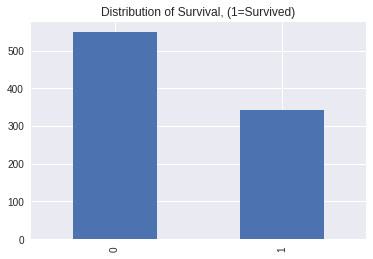

In [13]:
#看看幸存者和遇难者之间的比例
df.Survived.value_counts().plot(kind='bar')
plt.title('Distribution of Survival, (1=Survived)')
plt.show()

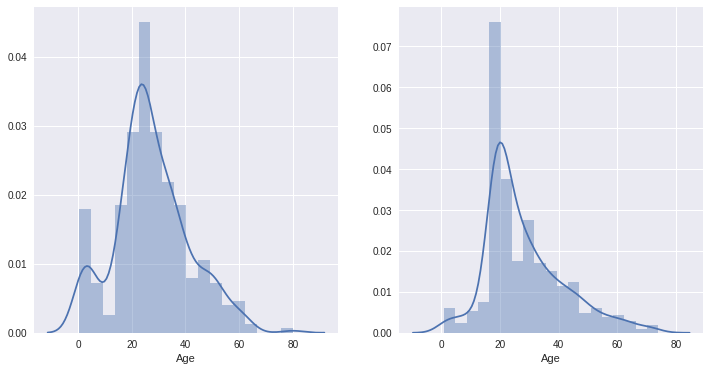

In [14]:
#分别显示幸存者和遇难者中，他们的年龄分布情况
fig,axes = plt.subplots(ncols=2,nrows=1)
fig.set_size_inches(12, 6)
sns.distplot(df.loc[df['Survived']==1,'Age'],ax=axes[0])
sns.distplot(df.loc[df['Survived']==0,'Age'],ax=axes[1])

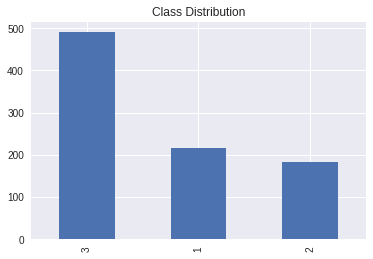

In [15]:
#不同仓位的乘客分布情况
df.Pclass.value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.show()

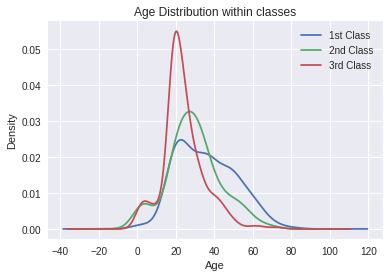

In [16]:
#不同仓位乘客的年龄分布
df.Age[df.Pclass==1].plot(kind='kde')
df.Age[df.Pclass==2].plot(kind='kde')
df.Age[df.Pclass==3].plot(kind='kde')
plt.xlabel('Age')
plt.title('Age Distribution within classes')
plt.legend(('1st Class', '2nd Class', '3rd Class'), loc='best')
plt.show()

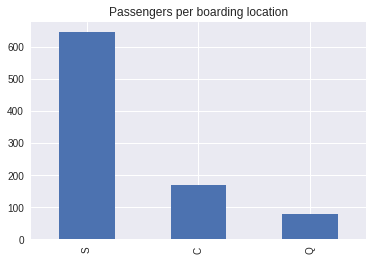

In [17]:
#不同登录港口登陆乘客的分布
df.Embarked.value_counts().plot(kind='bar')
plt.title('Passengers per boarding location')
plt.show()

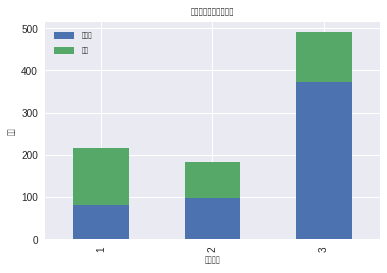

In [18]:
#看看各乘客等级的获救情况
fig = plt.figure()
fig.set(alpha=0.2)  #设定图表颜色alpha参数

Survived_0 = df.Pclass[df.Survived == 0].value_counts()
Survived_1 = df.Pclass[df.Survived == 1].value_counts()
df_pclass = pd.DataFrame({u'获救':Survived_1, u'未获救':Survived_0})
df_pclass.plot(kind='bar', stacked=True)
plt.title(u'各乘客等级的获救情况')
plt.xlabel(u'乘客等级')
plt.ylabel(u'人数')
plt.show()

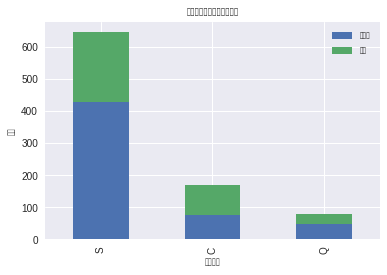

In [19]:
#看看各登录港口的获救情况
fig = plt.figure()
fig.set(alpha=0.2)  #设定图表颜色alpha参数

Survived_0 = df.Embarked[df.Survived == 0].value_counts()
Survived_1 = df.Embarked[df.Survived == 1].value_counts()
df_embarked = pd.DataFrame({u'获救':Survived_1, u'未获救':Survived_0})
df_embarked.plot(kind='bar', stacked=True)
plt.title(u'各登录港口乘客的获救情况')
plt.xlabel(u'登录港口')
plt.ylabel(u'人数')
plt.show()


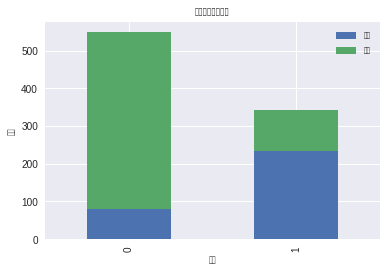

In [20]:
#各性别的获救情况
fig = plt.figure()
fig.set(alpha=0.2)  #设定图表颜色alpha参数

Survived_m = df.Survived[df.Sex == 'male'].value_counts()
Survived_f = df.Survived[df.Sex == 'female'].value_counts()
df_sex = pd.DataFrame({u'男性':Survived_m, u'女性':Survived_f})
df_sex.plot(kind='bar',stacked=True)
plt.title(u'按性别看获救情况')
plt.xlabel(u'性别')
plt.ylabel(u'人数')
plt.show()

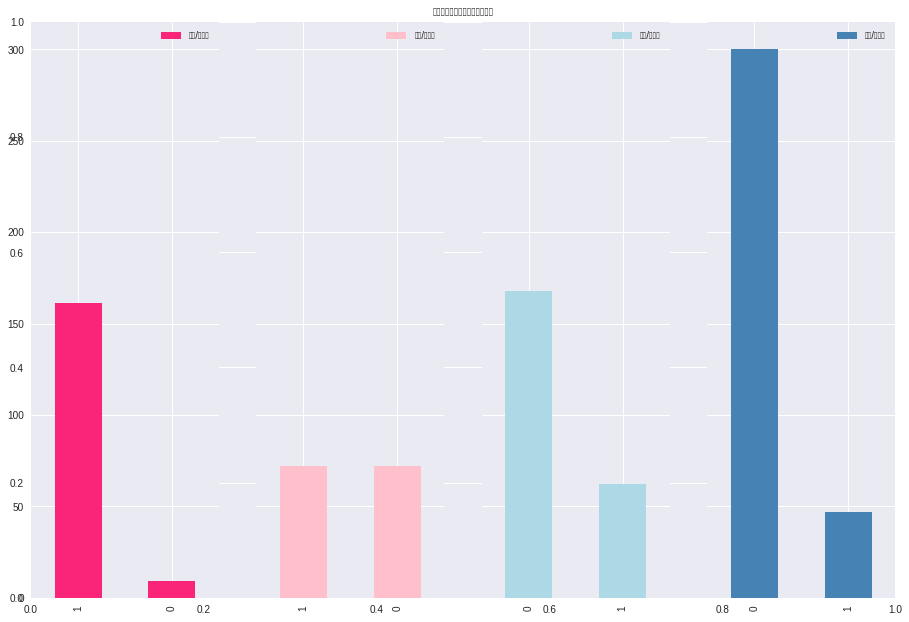

In [21]:
#不同舱位的男女获救情况
fig = plt.figure()
fig.set(alpha=0.65) #设置图像透明度，无所谓
plt.subplots_adjust(left=0.0,bottom=0.0,top=2,right=2)
plt.title(u'根据船舱等级和性别的获救情况')

ax1 = fig.add_subplot(141)
df.Survived[df.Sex == 'female'][df.Pclass != 3].value_counts().plot(kind='bar', 
                                                                        label='female highclass', color='#FA2479')
#ax1.set_xticklabels([u'获救',u'未获救'], rotation=0)
ax1.legend([u'女性/高级舱'], loc='best')

ax2 = fig.add_subplot(142, sharey=ax1)
df.Survived[df.Sex == 'female'][df.Pclass == 3].value_counts().plot(kind='bar',
                                                                        label='female low class', color='pink')
#ax2.set_xticklabels([u'获救',u'未获救'], rotation=0)
ax2.legend([u'女性/低级舱'], loc='best')

ax3 = fig.add_subplot(143, sharey=ax1)
df.Survived[df.Sex == 'male'][df.Pclass != 3].value_counts().plot(kind='bar',
                                                                        label='male highclass', color='lightblue')
#ax3.set_xticklabels([u'获救', u'未获救'], rotation=0)
ax3.legend([u'男性/高级舱'], loc='best')

ax4 = fig.add_subplot(144, sharey=ax1)
df.Survived[df.Sex == 'male'][df.Pclass == 3].value_counts().plot(kind='bar',
                                                                        label='male lowclass', color='steelblue')
#ax4.set_xticklabels([u'获救',u'未获救'], rotation=0)
plt.legend([u'男性/低级舱'], loc='best')

plt.show()


In [22]:
#那么堂兄弟和父母呢？大家族会有优势么?
g = df.groupby(['SibSp','Survived'])
df_tmp = pd.DataFrame(g.count()['PassengerId'])
df_tmp

PassengerId
SibSp Survived             
0     0                 398
      1                 210
1     0                  97
      1                 112
2     0                  15
      1                  13
3     0                  12
      1                   4
4     0                  15
      1                   3
5     0                   5
8     0                   7

In [23]:
g = df.groupby(['Parch', 'Survived'])
df_tmp = pd.DataFrame(g.count()['PassengerId'])
df_tmp

PassengerId
Parch Survived             
0     0                 445
      1                 233
1     0                  53
      1                  65
2     0                  40
      1                  40
3     0                   2
      1                   3
4     0                   4
5     0                   4
      1                   1
6     0                   1

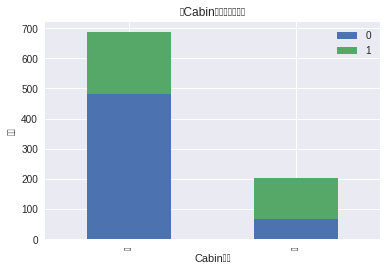

In [24]:
df_cabin = pd.DataFrame({u'有':df.loc[df['has_cabin']==1,'Survived'].value_counts(), u'无':df.loc[df['has_cabin']==0,'Survived'].value_counts()}).transpose()
df_cabin.plot(kind='bar', stacked=True)
plt.title(u'按Cabin有无看获救情况')
plt.xlabel(u'Cabin有无')
plt.ylabel(u'人数')
plt.show()

通常遇到缺值的情况，我们会有几种常见的处理方式<br>
1. 如果缺值的样本占总数比例极高，我们可能就直接舍弃了，作为特征加入的话，可能反倒带入噪音，影响最后的结果了
2. 如果缺值的样本适中，而该属性非连续值特征属性(比如说类目属性),那就把NaN作为一个新类别，加到类别特征中
3. 如果缺失值的样本适中，而该属性为连续值特征属性，有时候我们会考虑给定一个step(比如这里的age,我们可以考虑每隔2/3岁为一个步长),然后把它离散化，之后把NaN作为一个type加到属性类目中。
4. 有些情况下，缺失值个数并不是特别多，那我们也可以试着根据已有的值，拟合一下数据，补充上。本例中，后两种处理方式应该都是可行的， 我们先试试拟合补全吧(虽然说没有特别多的背景可供我们拟合，这不一定是一个多么好的选择)

因为逻辑回归建模时，需要输入的特征都是数值型特征，我们通常会先对类目型特征进行因子化/one-hot编码
什么叫做因子化/one-hot编码?举个例子:
以Embarked为例，原本一个属性维度，因为其取值可以是['S','C','Q'],而将其平展开为'Embarked_C','Embarked_S','Embarked_Q'三个属性
- 原本Embarked取值为S的，在此处的'Embarked_S'下取值为1, 在'Embarked_C'，‘Embarked_Q'下取值为0
- 原本Embarked取值为C的，在此处的’Embarked_C'下取值为1, 在‘Embarked_S','Embarked_Q'下取值为0
- 原本Embarked取值为Q的，在此处的'Embarked_Q'下取值为1, 在'Embarked_C','Embarked_S'下取值为0
我们使用pandas的“get_dummies”来完成这个工作，并拼接在原来的"data_train"之上，如上所示.

In [25]:
#热编码
dummies_Embarked = pd.get_dummies(df['Embarked'], prefix='Embarked')
dummies_Sex = pd.get_dummies(df['Sex'], prefix='Sex')
dummies_Pclass = pd.get_dummies(df['Pclass'], prefix='Pclass')
df = pd.concat([df, dummies_Embarked, dummies_Sex, dummies_Pclass], axis=1)
df.drop(['Pclass', 'Name', 'Sex', 'Ticket', 'Embarked'], axis=1, inplace=True)
df.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,has_cabin,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3
0,1,0,22.0,1,0,7.2500,0,0,0,1,0,1,0,0,1
1,2,1,38.0,1,0,71.2833,1,1,0,0,1,0,1,0,0
2,3,1,26.0,0,0,7.9250,0,0,0,1,1,0,0,0,1
3,4,1,35.0,1,0,53.1000,1,0,0,1,1,0,1,0,0
4,5,0,35.0,0,0,8.0500,0,0,0,1,0,1,0,0,1


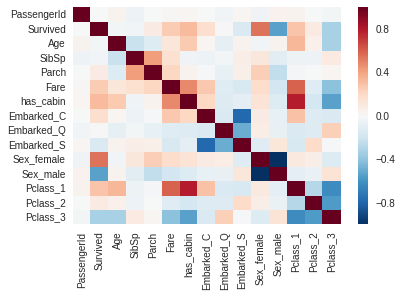

In [26]:
sns.heatmap(df.corr())

从上图我们可以看到乘客id信息、年龄、SibSp、跟类标的相关性很弱可以忽略不计。has_cabin和Pclass_1有正相关性，所以可以取其一来降低算法复杂度。